In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from neuraldistributions.models import transforms
from neuraldistributions.datasets import static

from multiprocessing import Pool

import os
device = "cuda"

In [10]:
import numpy as np
import torch

from neuraldistributions.datasets import mouse_static_loaders, extract_data_key
from neuraldistributions.models import poisson, zig, flowfa, ziffa, flowfa_ident
from neuraldistributions.trainers import base_trainer
from neuraldistributions.utility import get_loglikelihood

In [11]:
# setup data loading
random_seed=42
dataset_dir = "../project/data"
datasets = [
    "static_edited_dsampled.zip",
]
scan_id = [2, 1]
dataset_paths = [f"{dataset_dir}/{dataset}" for dataset in datasets]
areas = [["V1", "LM"]]
neurons_ns = [1000, 907]

In [12]:
dataset_index = 0
dataset_path = dataset_paths[dataset_index]
data_key = extract_data_key(dataset_path)
area = areas[dataset_index]
neurons_n = neurons_ns[dataset_index]

dataset_config = {
    "paths": [dataset_path],
    "seed": random_seed,
    "batch_size": 64,
    "area": area,
    "neurons_n": neurons_n,
    "normalize_images": True,
    "normalize_neurons": True,
    "return_more": True,
    "device": device,
    "shuffle_train": True,
}

dataloaders = mouse_static_loaders(**dataset_config)

100%|██████████| 5994/5994 [00:00<00:00, 294587.17it/s]


In [13]:
grid_mean_pred_config = {
    "type": "cortex",
    "input_dimensions": 2,
    "hidden_layers": 4,
    "hidden_features": 20,
    "nonlinearity": "ReLU",
    "final_tanh": True,
}

image_model_config = {
    "pad_input": False,
    "stack": -1,
    "layers": 4,
    "input_kern": 15,
    "gamma_input": 1,
    "gamma_readout": 2.439,
    "hidden_dilation": 1,
    "hidden_kern": 13,
    "hidden_channels": 64,
    "n_se_blocks": 0,
    "depth_separable": True,
    "share_features": False,
    "share_grid": False,
    "init_sigma": 0.4,
    "init_mu_range": 0.55,
    "gauss_type": "full",
    "grid_mean_predictor": grid_mean_pred_config,
}

In [14]:
# load model
model_name = "flowfa_ident"
d_latent = 3
sample_transform = "learned-leaky"
mean_transform = "learned"
per_neuron_transform = True
unit_variance_constraint = False

model_config = {
    "image_model_fn": "nnsysident.models.models.se2d_fullgaussian2d",
    "image_model_config": image_model_config,
    "d_latent": d_latent,
    "sample_transform": sample_transform,
    "mean_transform": mean_transform,
    "per_neuron_samples_transform": per_neuron_transform,
    "init_psi_diag_coef": 0.1,
    "init_C_coef": 0.1,
    "unit_variance_constraint": unit_variance_constraint,
}
model = flowfa_ident(dataloaders, random_seed, **model_config)

In [15]:
# get name of dataloader
index_name_of_dataloader = next(iter(dataloaders["train"]))

# get indices of repeated samples
indexes = np.arange(len(dataloaders["image_ids"][index_name_of_dataloader]["test"]))
u, inv = (np.unique(dataloaders["image_ids"][index_name_of_dataloader]["test"], return_inverse=True))

# get the indices of the first ten repeated samples
img_indexes = indexes[inv == inv[0]]
print(img_indexes)

[0 1 2 3 4 5 6 7 8 9]


In [16]:
# sanity check to see if the wanted samples transform is actually loaded
print(model.mean_transform)

MeanTransfom(
  (f): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)


102
435
860
270
106
71
700
20
614


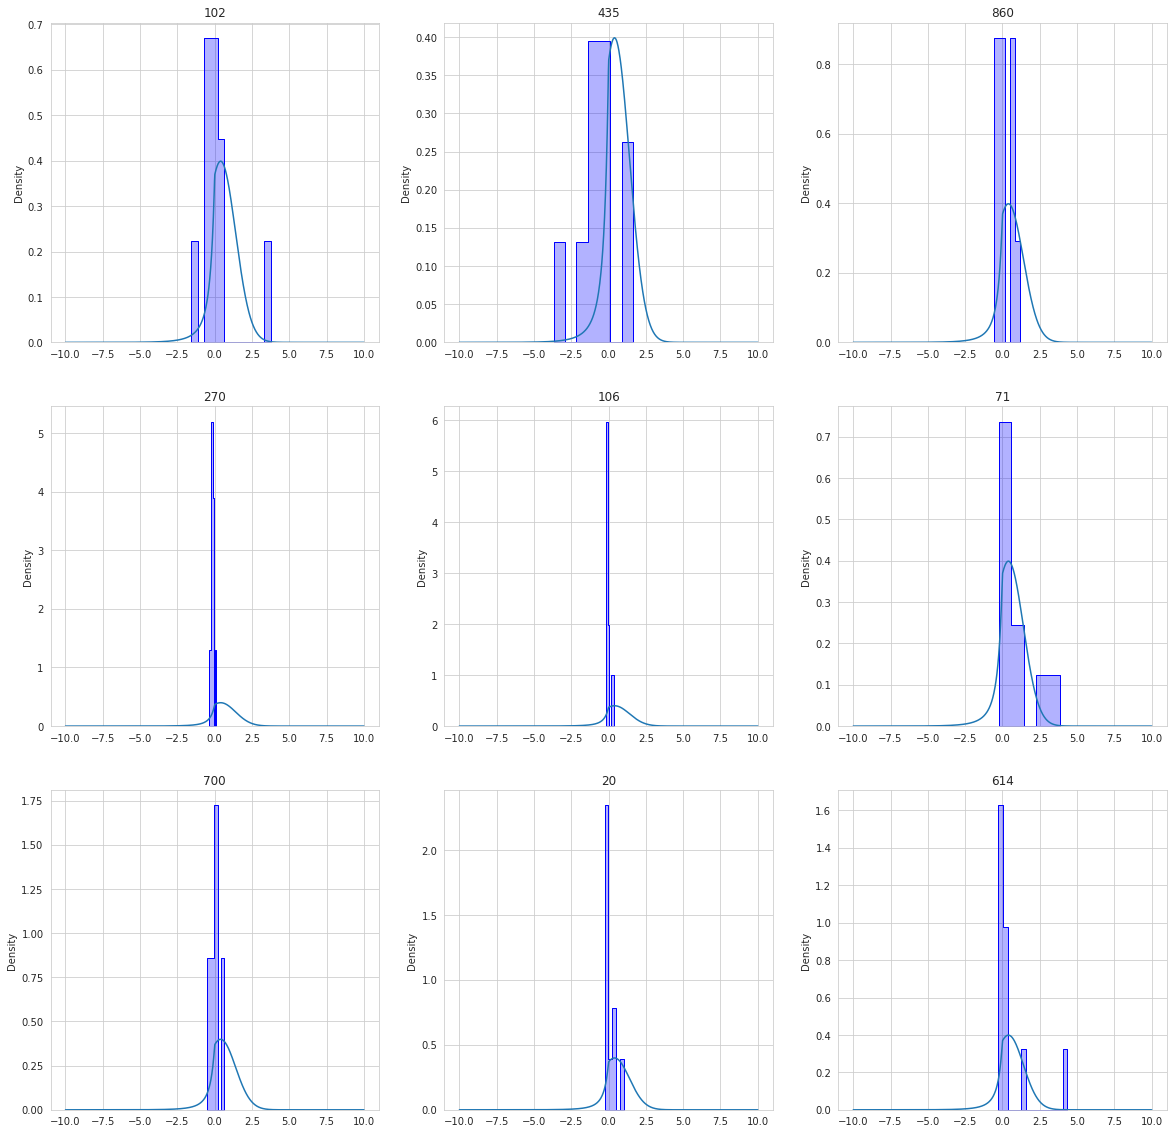

In [17]:
from matplotlib.pyplot import figure

# print distributions of neurons before training
# get the first batch (it contains the needed images and responses)
batch = (next(iter(dataloaders["test"][index_name_of_dataloader])))
inputs, targets = batch[:2]
# get the mean of the latent gaussian
mu = model.forward(*batch, data_key=None).to("cpu")
# create array with points of interest for responses (interval from -10 to 10)
points = torch.linspace(-10,10, 1000).to(device)
   
# get transformed targets (for log likelihood) and logdet
transformed_targets, logdet = model.sample_transform(points.unsqueeze(0).T.repeat_interleave(1000,dim=1).to(device))

# get random neurons for the plot
random_neurons = np.random.choice(1000,9)



# create plot for each neuron
fig, ax = plt.subplots(3,3, figsize=(20,20))
for i, neuron in enumerate(random_neurons):
    print(neuron)
    
    # create normal distribution (gaussian with mu of the neuron and std=1)
    normal = torch.distributions.normal.Normal(mu[img_indexes[0]][neuron], torch.tensor([1.0]))
    # get log likelihood with log prob and log det, and get likelihood
    values_before_normal = normal.log_prob(transformed_targets.detach().to("cpu"))
    values_before = torch.exp(values_before_normal.detach() + logdet.detach().to("cpu"))
    
    
    ax[i//3][i%3].plot(points.detach().cpu(), values_before[:,neuron])
    ax[i//3][i%3].set_title(str(neuron))
    sns.histplot(targets[img_indexes][:,neuron].detach().cpu(), ax=ax[i//3][i%3], stat="density", element="step", color="blue", alpha=0.3)
    #ax[i//3][i%3].hist(targets[img_indexes][:,neuron].detach().cpu().numpy(), color="blue", density=True)
plt.show()

In [18]:
# train model with config
trainer_config = {
    "epochs": 500,
    "device": "cuda",
    "lr": 0.005,
    "use_avg_loss": True
}
out = None
## The following line would train the model (upon availability of the dataset)
out = base_trainer(model, dataloaders, random_seed, **trainer_config)

Score improved (nan --> 1861.736450).


100%|██████████| 70/70 [00:05<00:00, 12.89it/s]


Epoch 1/500 | train loss: 1861.496338 | val loss: 1557.374023
Score improved (1861.736450 --> 1557.374023).


100%|██████████| 70/70 [00:05<00:00, 12.92it/s]


Epoch 2/500 | train loss: 1581.249146 | val loss: 1534.623901
Score improved (1557.374023 --> 1534.623901).


100%|██████████| 70/70 [00:05<00:00, 12.92it/s]


Epoch 3/500 | train loss: 1481.292969 | val loss: 1527.303589
Score improved (1534.623901 --> 1527.303589).


100%|██████████| 70/70 [00:05<00:00, 12.92it/s]


Epoch 4/500 | train loss: 1616.090698 | val loss: 1521.080688
Score improved (1527.303589 --> 1521.080688).


100%|██████████| 70/70 [00:05<00:00, 12.94it/s]


Epoch 5/500 | train loss: 1577.033447 | val loss: 1525.755615
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.93it/s]


Epoch 6/500 | train loss: 1468.127197 | val loss: 1521.121826
EarlyStopping counter: 2 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.95it/s]


Epoch 7/500 | train loss: 1537.476074 | val loss: 1520.443237
Score improved (1521.080688 --> 1520.443237).


100%|██████████| 70/70 [00:05<00:00, 12.94it/s]


Epoch 8/500 | train loss: 1488.425781 | val loss: 1520.930176
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.94it/s]


Epoch 9/500 | train loss: 1505.658081 | val loss: 1520.229614
Score improved (1520.443237 --> 1520.229614).


100%|██████████| 70/70 [00:05<00:00, 12.93it/s]


Epoch 10/500 | train loss: 1556.262329 | val loss: 1520.949219
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.94it/s]


Epoch 11/500 | train loss: 1590.727905 | val loss: 1518.055908
Score improved (1520.229614 --> 1518.055908).


100%|██████████| 70/70 [00:05<00:00, 12.94it/s]


Epoch 12/500 | train loss: 1478.740112 | val loss: 1518.683105
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.79it/s]


Epoch 13/500 | train loss: 1540.660767 | val loss: 1519.273926
EarlyStopping counter: 2 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.94it/s]


Epoch 14/500 | train loss: 1529.668335 | val loss: 1522.547363
EarlyStopping counter: 3 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.91it/s]


Epoch 15/500 | train loss: 1613.352173 | val loss: 1519.309692
EarlyStopping counter: 4 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.91it/s]


Epoch 16/500 | train loss: 1474.368286 | val loss: 1518.025513
Score improved (1518.055908 --> 1518.025513).


100%|██████████| 70/70 [00:05<00:00, 12.73it/s]


Epoch 17/500 | train loss: 1631.888184 | val loss: 1515.240479
Score improved (1518.025513 --> 1515.240479).


100%|██████████| 70/70 [00:05<00:00, 13.11it/s]


Epoch 18/500 | train loss: 1514.645874 | val loss: 1516.803345
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.96it/s]


Epoch 19/500 | train loss: 1529.592651 | val loss: 1516.571777
EarlyStopping counter: 2 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.96it/s]


Epoch 20/500 | train loss: 1507.160522 | val loss: 1513.049683
Score improved (1515.240479 --> 1513.049683).


100%|██████████| 70/70 [00:05<00:00, 12.57it/s]


Epoch 21/500 | train loss: 1455.674316 | val loss: 1515.638672
EarlyStopping counter: 1 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.15it/s]


Epoch 22/500 | train loss: 1530.213135 | val loss: 1521.137451
EarlyStopping counter: 2 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.94it/s]


Epoch 23/500 | train loss: 1483.695312 | val loss: 1516.139893
EarlyStopping counter: 3 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.94it/s]


Epoch 24/500 | train loss: 1524.192871 | val loss: 1521.121826
EarlyStopping counter: 4 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.94it/s]


Epoch 25/500 | train loss: 1461.719482 | val loss: 1522.634277
EarlyStopping counter: 5 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.93it/s]


Epoch 26/500 | train loss: 1487.163208 | val loss: 1518.515503
EarlyStopping counter: 6 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.91it/s]


Epoch 27/500 | train loss: 1458.731689 | val loss: 1517.498779
EarlyStopping counter: 7 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.93it/s]


Epoch 28/500 | train loss: 1464.120483 | val loss: 1522.512207
EarlyStopping counter: 8 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.93it/s]


Epoch 29/500 | train loss: 1599.687866 | val loss: 1516.145020
EarlyStopping counter: 9 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.93it/s]


Epoch 30/500 | train loss: 1495.814209 | val loss: 1516.174316
EarlyStopping counter: 10 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.91it/s]


Epoch 31/500 | train loss: 1499.863892 | val loss: 1515.604004
EarlyStopping counter: 11 out of 50
Epoch    31: reducing learning rate of group 0 to 1.5000e-03.
Retrieve best model..
Applying changes..


100%|██████████| 70/70 [00:05<00:00, 12.86it/s]


Epoch 32/500 | train loss: 1484.712402 | val loss: 1518.462646
EarlyStopping counter: 12 out of 50
Retrieve best model..


100%|██████████| 70/70 [00:05<00:00, 12.87it/s]


Epoch 33/500 | train loss: 1439.328613 | val loss: 1517.433838
EarlyStopping counter: 13 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.91it/s]


Epoch 34/500 | train loss: 1436.381958 | val loss: 1519.191650
EarlyStopping counter: 14 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.94it/s]


Epoch 35/500 | train loss: 1548.330078 | val loss: 1521.055176
EarlyStopping counter: 15 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.56it/s]


Epoch 36/500 | train loss: 1480.194946 | val loss: 1517.150391
EarlyStopping counter: 16 out of 50


100%|██████████| 70/70 [00:05<00:00, 11.67it/s]


Epoch 37/500 | train loss: 1512.020630 | val loss: 1515.873779
EarlyStopping counter: 17 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.16it/s]


Epoch 38/500 | train loss: 1609.470825 | val loss: 1515.791504
EarlyStopping counter: 18 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.45it/s]


Epoch 39/500 | train loss: 1503.899048 | val loss: 1516.572144
EarlyStopping counter: 19 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.98it/s]


Epoch 40/500 | train loss: 1556.870117 | val loss: 1519.651367
EarlyStopping counter: 20 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.81it/s]


Epoch 41/500 | train loss: 1553.446167 | val loss: 1518.753174
EarlyStopping counter: 21 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.92it/s]


Epoch 42/500 | train loss: 1520.041382 | val loss: 1520.899170
EarlyStopping counter: 22 out of 50
Epoch    42: reducing learning rate of group 0 to 1.5000e-03.
Retrieve best model..


100%|██████████| 70/70 [00:05<00:00, 12.90it/s]


Epoch 43/500 | train loss: 1465.173096 | val loss: 1515.811279
EarlyStopping counter: 23 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.35it/s]


Epoch 44/500 | train loss: 1473.989258 | val loss: 1515.303955
EarlyStopping counter: 24 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.37it/s]


Epoch 45/500 | train loss: 1454.725464 | val loss: 1516.158203
EarlyStopping counter: 25 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.98it/s]


Epoch 46/500 | train loss: 1408.980713 | val loss: 1516.665894
EarlyStopping counter: 26 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.95it/s]


Epoch 47/500 | train loss: 1402.704712 | val loss: 1516.541748
EarlyStopping counter: 27 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.82it/s]


Epoch 48/500 | train loss: 1462.706421 | val loss: 1516.375610
EarlyStopping counter: 28 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.88it/s]


Epoch 49/500 | train loss: 1486.110352 | val loss: 1516.716431
EarlyStopping counter: 29 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.02it/s]


Epoch 50/500 | train loss: 1450.644653 | val loss: 1516.484375
EarlyStopping counter: 30 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.92it/s]


Epoch 51/500 | train loss: 1497.451904 | val loss: 1515.802002
EarlyStopping counter: 31 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.14it/s]


Epoch 52/500 | train loss: 1453.900513 | val loss: 1517.103882
EarlyStopping counter: 32 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.94it/s]


Epoch 53/500 | train loss: 1448.713013 | val loss: 1516.640381
EarlyStopping counter: 33 out of 50
Epoch    53: reducing learning rate of group 0 to 4.5000e-04.
Retrieve best model..


100%|██████████| 70/70 [00:05<00:00, 13.07it/s]


Epoch 54/500 | train loss: 1502.757080 | val loss: 1513.910034
EarlyStopping counter: 34 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.93it/s]


Epoch 55/500 | train loss: 1432.457275 | val loss: 1513.839844
EarlyStopping counter: 35 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.94it/s]


Epoch 56/500 | train loss: 1517.504028 | val loss: 1514.723999
EarlyStopping counter: 36 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.94it/s]


Epoch 57/500 | train loss: 1458.048828 | val loss: 1514.832031
EarlyStopping counter: 37 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.93it/s]


Epoch 58/500 | train loss: 1430.099976 | val loss: 1515.285400
EarlyStopping counter: 38 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.94it/s]


Epoch 59/500 | train loss: 1353.386963 | val loss: 1515.236450
EarlyStopping counter: 39 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.89it/s]


Epoch 60/500 | train loss: 1404.785034 | val loss: 1515.603760
EarlyStopping counter: 40 out of 50


100%|██████████| 70/70 [00:05<00:00, 13.10it/s]


Epoch 61/500 | train loss: 1575.800903 | val loss: 1515.788086
EarlyStopping counter: 41 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.95it/s]


Epoch 62/500 | train loss: 1472.970215 | val loss: 1516.420044
EarlyStopping counter: 42 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.94it/s]


Epoch 63/500 | train loss: 1455.640381 | val loss: 1515.714844
EarlyStopping counter: 43 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.91it/s]


Epoch 64/500 | train loss: 1523.255005 | val loss: 1516.080444
EarlyStopping counter: 44 out of 50
Epoch    64: reducing learning rate of group 0 to 1.3500e-04.
Retrieve best model..


100%|██████████| 70/70 [00:05<00:00, 12.98it/s]


Epoch 65/500 | train loss: 1638.829102 | val loss: 1513.121948
EarlyStopping counter: 45 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.88it/s]


Epoch 66/500 | train loss: 1389.929077 | val loss: 1513.343994
EarlyStopping counter: 46 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.88it/s]


Epoch 67/500 | train loss: 1401.815674 | val loss: 1513.436768
EarlyStopping counter: 47 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.87it/s]


Epoch 68/500 | train loss: 1358.658936 | val loss: 1513.572998
EarlyStopping counter: 48 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.89it/s]


Epoch 69/500 | train loss: 1457.981812 | val loss: 1513.763306
EarlyStopping counter: 49 out of 50


100%|██████████| 70/70 [00:05<00:00, 12.87it/s]


Epoch 70/500 | train loss: 1433.647705 | val loss: 1514.093262
EarlyStopping counter: 50 out of 50
Early stopping at epoch 69. Best val loss: 1513.050
Retrieve best model..


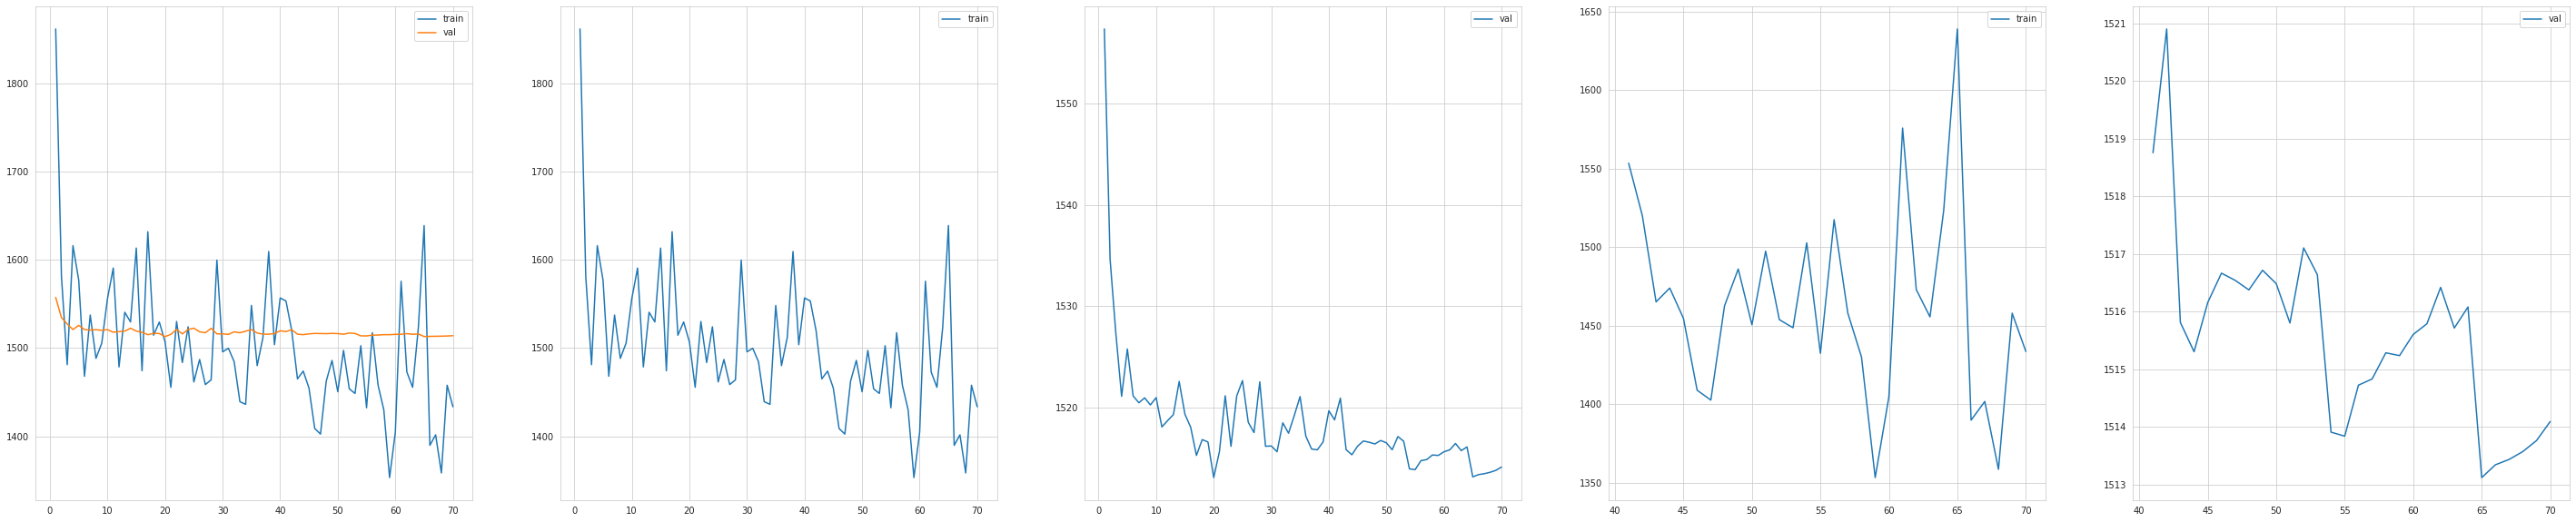

In [19]:
# plot training losses if we trained (additional plot after 40 epochs so we can see the later values better)
if out is not None:
    fig, ax = plt.subplots(1,5,figsize=(50,10))
    ax[0].plot((np.arange(len(out[1][0]))+1), out[1][0], label="train")
    ax[0].plot((np.arange(len(out[1][0]))+1), out[1][1], label="val")
    ax[1].plot((np.arange(len(out[1][0]))+1), out[1][0], label="train")
    ax[2].plot((np.arange(len(out[1][0]))+1), out[1][1], label="val")
    ax[3].plot((np.arange(len(out[1][0]))+1)[40:], out[1][0][40:], label="train")
    ax[4].plot((np.arange(len(out[1][0]))+1)[40:], out[1][1][40:], label="val")
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    ax[3].legend()
    ax[4].legend()
    plt.show()

In [20]:
print(model)

FlowFA_Ident(
  (encoding_model): Encoder(
    (core): SE2dCore(
      (_input_weights_regularizer): LaplaceL2norm(
        (laplace): Laplace()
      )
      (features): Sequential(
        (layer0): Sequential(
          (conv): Conv2d(1, 64, kernel_size=(15, 15), stride=(1, 1), bias=False)
          (norm): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
          (nonlin): ELU(alpha=1.0, inplace=True)
        )
        (layer1): Sequential(
          (ds_conv): DepthSeparableConv2d(
            (in_depth_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (spatial_conv): Conv2d(64, 64, kernel_size=(13, 13), stride=(1, 1), padding=(6, 6), groups=64, bias=False)
            (out_depth_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
          (norm): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
          (nonlin): ELU(alpha=1.0, inplace=True)
        )
     

102
435
860
270
106
71
700
20
614


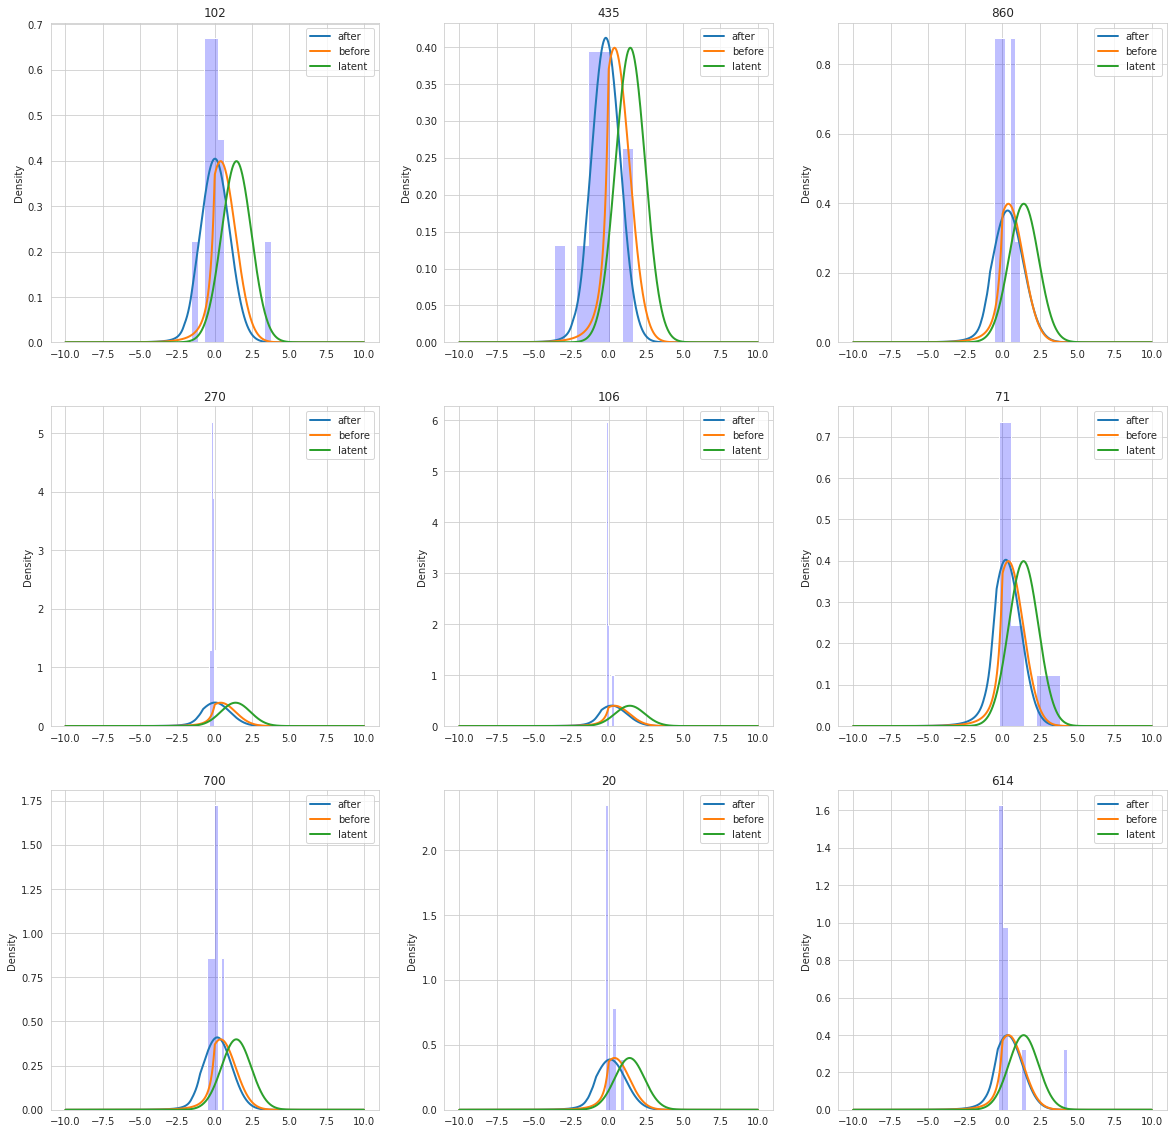

In [21]:
# print distributions after training
# get the mean of the latent gaussian with the same batch as before (these changed since the mean model trained as well)
mu = model.forward(*batch, data_key=None).to("cpu")

# get transformed targets (for log likelihood) and logdet
transformed_targets, logdet = model.sample_transform(points.unsqueeze(0).T.repeat_interleave(1000,dim=1).to(device))

# create plot for each neuron
fig, ax = plt.subplots(3,3, figsize=(20,20))
for i, neuron in enumerate(random_neurons):
    print(neuron) 
    # create normal distribution (gaussian with mu of the neuron and std=1)
    normal = torch.distributions.normal.Normal(mu[img_indexes[0]][neuron], torch.tensor([1.0]))
    
    # get log likelihood with log prob and log det, and get likelihood
    values = normal.log_prob(transformed_targets.detach().to("cpu"))
    
    ax[i//3][i%3].plot(points.detach().cpu(), torch.exp(values.detach()[:,neuron] + logdet.detach().to("cpu")[:,neuron]), label="after", linewidth=2)
    ax[i//3][i%3].plot(points.detach().cpu(), values_before[:,neuron], label="before", linewidth=2)
    ax[i//3][i%3].plot(points.detach().cpu(), torch.exp(normal.log_prob(points.detach().cpu()).detach()), label="latent", linewidth=2)
    ax[i//3][i%3].set_title(str(neuron))
    ax[i//3][i%3].legend()
    sns.histplot(targets[img_indexes][:,neuron].detach().cpu(), ax=ax[i//3][i%3], stat="density", element="step", color="blue", alpha=0.25, edgecolor=None)
    #ax[i//3][i%3].hist(targets[img_indexes][:,neuron].detach().cpu().numpy(), color="blue", density=True)

plt.show()
fig.savefig("images/FlowFA-Ident.pdf", format="pdf",dpi=300)

In [22]:
from utility_extended import * 

In [23]:
print(f"Train loss: {calcLossForDataset(model, dataloaders['train'], 1000, True)}\nVal loss: {calcLossForDataset(model, dataloaders['validation'], 1000, True)}\nTest loss: {calcLossForDataset(model, dataloaders['test'], 1000, True)}")

Train loss: 2.052277892915796
Val loss: 1.9950805678602899
Test loss: 1.9967034550801483


In [24]:
torch.save(model, "./models/FlowFA-Ident")